### Sentiment-based Investment Signal 

The purpose of this notebook is to show how to use YUKKA sentiment data to create a simple investment signal that has the capacity to outperform the market. We use the `yl_data_api_client` package to easily retrieve both sentiment and price data. 

This notebook follows along closely with [this Medium article](https://medium.com/@api_37352?p=d58bc733f08b), written by one of our colleagues at YUKKA. 

As noted in the article, the signal we created in this notebook might not be applicable to a wider range of stocks. Moreover, it is somewhat sensitive to input parameters, like the size of the rolling average window. As such, this code is merely for illustrative purposes and does not comprise financial advice. 

In [1]:
%matplotlib notebook

In [42]:
import sys
from datetime import datetime 

import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
try:
    from yl_data_api_client import YLDataAPIClient
except ImportError:  # means yl_data_api_client isn't installed; attempt to add to system path and reimport 
    sys.path.append("..")
    from yl_data_api_client import YLDataAPIClient
    

matplotlib.rcParams['figure.figsize'] = (9.5, 8)

In [59]:
api_version = "7-2"
api_env = "prod"

company = "apple"

client = YLDataAPIClient(
    api_version=api_version, 
    api_env=api_env,
    use_cache=False
)

company_client = client.company[company]

In [60]:
date_from = "2015-01-01"
date_to = datetime.now()

date_range = dict(
    date_from=date_from,
    date_to=date_to
)

# first get sentiment counts 
data_df = client.company[company].sentiment_counts_ts(
    **date_range).drop(columns=["nf"]).set_index("date", drop=True)

# now get price data. 
price = client.trading.company[company].yl_price(**date_range)
price_df = pd.DataFrame(price["prices"])
price_df.date = pd.to_datetime(price_df.date).dt.tz_localize("UTC")
price_df.set_index("date", drop=True, inplace=True)

# let's forward fill price over the weekend after adding price data to our sentiment_counts_ts DataFrame
data_df.loc[:, "price"] = price_df.loc[:, "price"]
data_df.loc[:, "price"].ffill(inplace=True)

# now inspect our newly created DataFrame containing sentiment counts and price data! 
data_df

pos   neu   neg    price
date                                                
2015-01-01 00:00:00+00:00   281   136    99      NaN
2015-01-02 00:00:00+00:00   327   189   142   27.332
2015-01-03 00:00:00+00:00   144    94    67   27.332
2015-01-04 00:00:00+00:00   186    86    53   27.332
2015-01-05 00:00:00+00:00   783   372   183   26.562
...                         ...   ...   ...      ...
2022-01-16 00:00:00+00:00   705   407   256  173.070
2022-01-17 00:00:00+00:00  1528   854   404  173.070
2022-01-18 00:00:00+00:00  2207  1356  1054  169.800
2022-01-19 00:00:00+00:00  1869  1466  1042  166.230
2022-01-20 00:00:00+00:00  2001  1393  1323  164.510

[2577 rows x 4 columns]

In [61]:
# now that we have our lightly preprocessed data, we can follow along from Alex's medium article 
# Let's start by applying a rolling average low-pass filter to our sentiment data.  

data_df["sentiment"] = np.log((1 + data_df["pos"]) / (1 + data_df["neg"]))
data_df["30d_sentiment"] = data_df["sentiment"].rolling(30).mean()
data_df["90d_sentiment"] = data_df["sentiment"].rolling(90).mean()

<IPython.core.display.Javascript object>


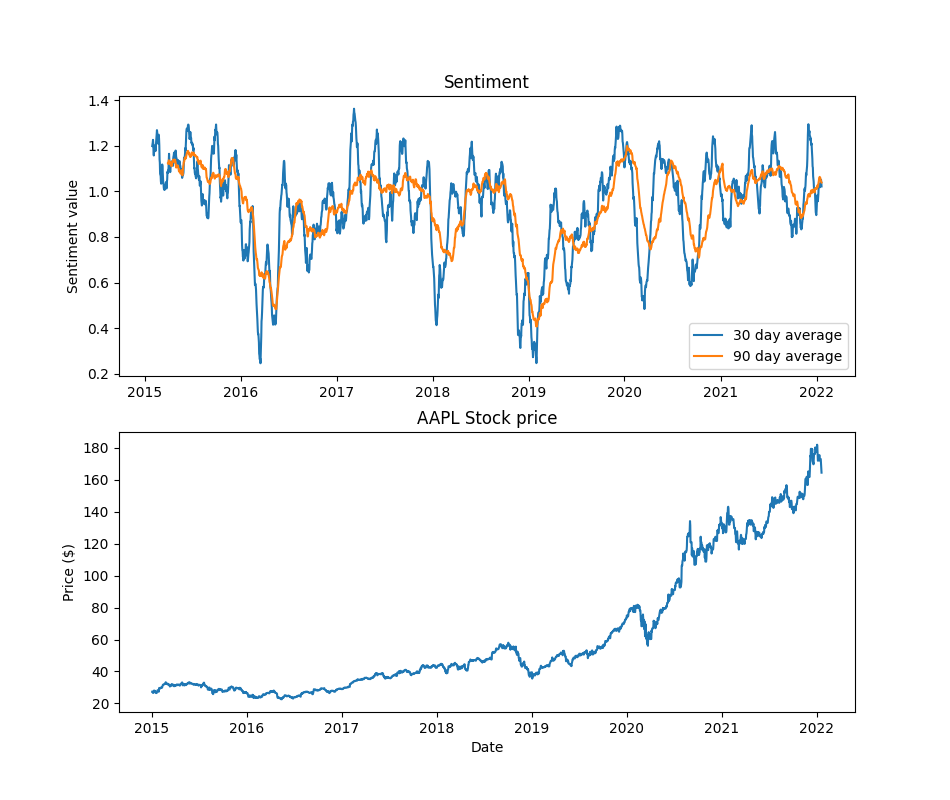

In [62]:
# now let's plot our low-pass filtered sentiment data along with the price of our stock of interest. 
fig, axes = plt.subplots(2, 1)

ax = axes[0]
ax.plot(data_df["30d_sentiment"], label="30 day average")
ax.plot(data_df["90d_sentiment"], label="90 day average")
ax.legend()
ax.set_ylabel("Sentiment value")
ax.set_title("Sentiment")

ax = axes[1]
ax.plot(data_df["price"])
ax.set_ylabel("Price ($)")
ax.set_title("AAPL Stock price")
ax.set_xlabel("Date");

In [63]:
# now let's build our investment signal. 
# We first take a rolling z-score using our filtered sentiment data, and then after further filtering and scaling,
# we clip the signal below some threshold. 
# This model is sensitive to the size of these rolling windows and the threshold value. 

threshold = 15
signal_df = data_df.copy()
signal_df["z_score"] = ((signal_df["30d_sentiment"] - signal_df["90d_sentiment"]) /
                        signal_df["sentiment"].rolling(90).std())
# as we've done a rolling average, we need to drop first 90 values from data frame
signal_df = signal_df.iloc[90:]
signal_df["z_score"] = (signal_df["z_score"].clip(lower=-0.5, upper=0.5) + 0.5) * 100
signal_df["z_score"] = signal_df["z_score"].ewm(10).mean().ewm(5).mean()
signal_df["signal"] = signal_df["z_score"].apply(lambda x: 1 if x > threshold else 0)

<IPython.core.display.Javascript object>


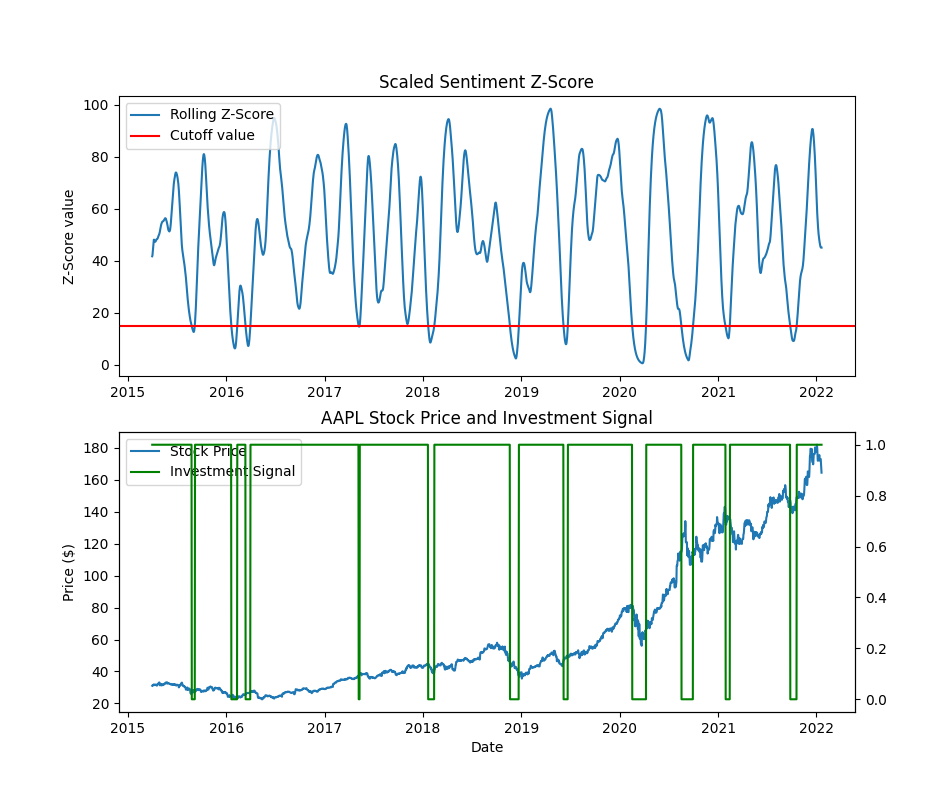

In [64]:
fig, axes = plt.subplots(2, 1)

ax = axes[0]
ax.plot(signal_df["z_score"], label="Rolling Z-Score")
ax.axhline(y=threshold, color="red", label="Cutoff value")
ax.legend()
ax.set_ylabel("Z-Score value")
ax.set_title("Scaled Sentiment Z-Score")

ax = axes[1]
ln0 = ax.plot(signal_df["price"], label="Stock Price")
ax.set_ylabel("Price ($)")
ax.set_title("AAPL Stock Price and Investment Signal")
ax.set_xlabel("Date");
ax_t = ax.twinx()
ln1 = ax_t.plot(
    signal_df["signal"].astype(int), 
    color="green", 
    label="Investment Signal")

lns = ln0 + ln1
labs = [ln.get_label() for ln in lns]
ax.legend(lns, labs)

In [65]:
# now let's evaluate the performance of our investment signal 

signal_df["signal"] = signal_df["signal"].shift(1).fillna(0)
signal_df["log_ret"] = np.log(1 + signal_df["price"].pct_change().fillna(0))
signal_df["managed"] = np.exp((signal_df["log_ret"] * signal_df["signal"]).cumsum()) - 1
signal_df["unmanaged"] = np.exp((signal_df["log_ret"]).cumsum()) - 1
signal_df["diff"] = np.exp((signal_df["log_ret"] * (signal_df["signal"] - 1)).cumsum()) - 1

signal_df[["price", "log_ret", "signal", "managed", "unmanaged", "diff"]]

price   log_ret  signal   managed  unmanaged  \
date                                                                        
2015-04-01 00:00:00+00:00   31.062  0.000000     0.0  0.000000   0.000000   
2015-04-02 00:00:00+00:00   31.330  0.008591     1.0  0.008628   0.008628   
2015-04-03 00:00:00+00:00   31.330  0.000000     1.0  0.008628   0.008628   
2015-04-04 00:00:00+00:00   31.330  0.000000     1.0  0.008628   0.008628   
2015-04-05 00:00:00+00:00   31.330  0.000000     1.0  0.008628   0.008628   
...                            ...       ...     ...       ...        ...   
2022-01-16 00:00:00+00:00  173.070  0.000000     1.0  6.502038   4.571760   
2022-01-17 00:00:00+00:00  173.070  0.000000     1.0  6.502038   4.571760   
2022-01-18 00:00:00+00:00  169.800 -0.019075     1.0  6.360294   4.466486   
2022-01-19 00:00:00+00:00  166.230 -0.021249     1.0  6.205545   4.351555   
2022-01-20 00:00:00+00:00  164.510 -0.010401     1.0  6.130989   4.296182   

                              diff  
date                                
2015-04-01 00:00:00+00:00  0.00000  
2015-04-02 00:00:00+00:00  0.00000  
2015-04-03 00:00:00+00:00  0.00000  
2015-04-04 00:00:00+00:00  0.00000  
2015-04-05 00:00:00+00:00  0.00000  
...                            ...  
2022-01-16 00:00:00+00:00  0.34644  
2022-01-17 00:00:00+00:00  0.34644  
2022-01-18 00:00:00+00:00  0.34644  
2022-01-19 00:00:00+00:00  0.34644  
2022-01-20 00:00:00+00:00  0.34644  

[2487 rows x 6 columns]

<IPython.core.display.Javascript object>


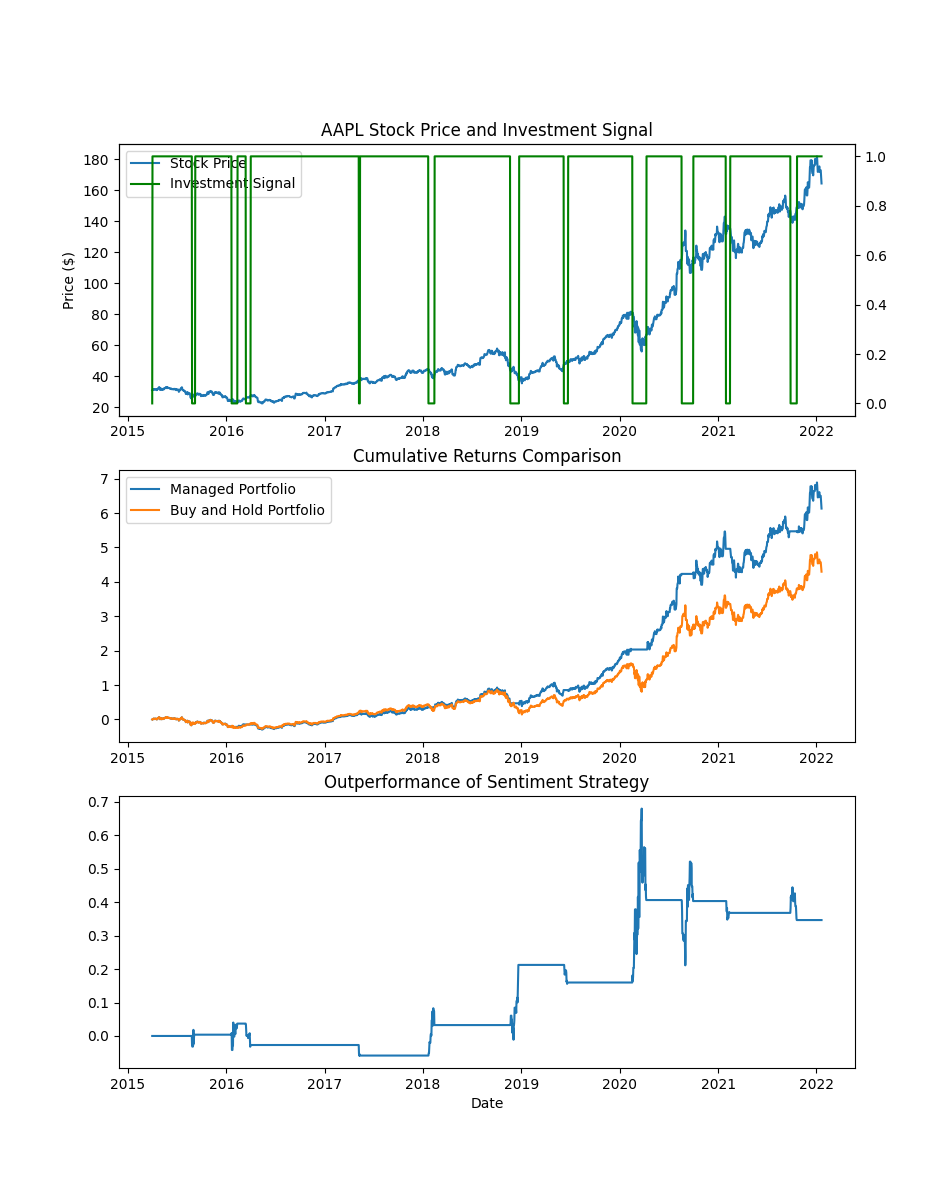

In [66]:
fig, axes = plt.subplots(3, 1, figsize=(9.5, 12))

ax = axes[0]
ln0 = ax.plot(signal_df["price"], label="Stock Price")
ax.set_ylabel("Price ($)")
ax.set_title("AAPL Stock Price and Investment Signal")
ax_t = ax.twinx()
ln1 = ax_t.plot(
    signal_df["signal"].astype(int), 
    color="green", 
    label="Investment Signal")

lns = ln0 + ln1
labs = [ln.get_label() for ln in lns]
ax.legend(lns, labs)

ax = axes[1]
ax.plot(signal_df["managed"], label="Managed Portfolio")
ax.plot(signal_df["unmanaged"], label="Buy and Hold Portfolio")
ax.legend()
ax.set_title("Cumulative Returns Comparison")

ax = axes[2]
ax.plot(signal_df["diff"])
ax.set_title("Outperformance of Sentiment Strategy")
ax.set_xlabel("Date");